In [1]:
import sys
sys.path.append('/home/huangbo/Desktop/objectdetection/') #Give local path to objectdetection repository
import os.path
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import model_from_json
from keras.backend import set_image_dim_ordering
set_image_dim_ordering('tf')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [24]:
def predict_single(model, img_patch):
    """
    Predicts the response maps of a single image map. Model should output the response map of same
    size as img_patch.
    :param model: A keras model.
    :param img_patch: Image patch of form (batch_size, h, w, channels).
    :return:
    """
    patch_size = model.input_shape[1:3]
    #img_patch_norm = normalize_image_channelwise(img_patch)
    img_patch_norm = np.expand_dims(img_patch, 0)
    response_map = model.predict(img_patch_norm)
    return np.reshape(response_map.squeeze(), patch_size + (response_map.shape[-1],))

def predict_complete(model, img_data):
    """
    Predicts response map of image having size greater than model input. The response map for the
     image is calculated by finding response maps for smaller overlapping images.
    :param model: Model on which to run the predictions.
    :param img_data: Image of shape (h, w, n_channels)
    :return: Predicted response map
    """
    patch_size = model.input_shape[1:3]
    step_size = (0.8 * np.array(patch_size)).astype(np.uint32)
    # resolution of response map should be same as img_data and channels should be no of channel in model output.
    out_response = np.zeros(img_data.shape[:2] + (model.output_shape[-1],))
    for i in range(0, img_data.shape[0], step_size[0]):
        x = img_data.shape[0] - patch_size[0] if i + patch_size[0] > img_data.shape[0] else i
        for j in range(0, img_data.shape[1], step_size[1]):
            y = img_data.shape[1] - patch_size[1] if j + patch_size[1] > img_data.shape[1] else j
            response_map = predict_single(model, img_data[x:x + patch_size[0], y:y + patch_size[1], :])
            out_response[x:x + patch_size[0], y:y + patch_size[1], :] = np.maximum(
                out_response[x:x + patch_size[0], y:y + patch_size[1], :], response_map)
    return out_response

def compress_as_label(response_maps, threshold=0.5):
    """
    Compresses probability  response maps as labels. First channel must be background response map.
    :param response_maps: List of response maps of shape (...,_channels)
    :return: Compressed label of shape (...) with each location containing the index of channel with max prob.
    """
    n_channels = response_maps.shape[-1]
    if n_channels == 1:  # binary segmentation
        out_response_map = np.zeros(response_maps.shape)
        out_response_map[response_maps > threshold] = 1
        return np.squeeze(out_response_map, axis=-1)
    else:
        return np.argmax(response_maps, -1)

In [3]:
model_dir = "/home/huangbo/objectdetection/objectdetection/huangbo_ws/models/06.18_resnet_256/"
model_definition = model_dir + "model.json"
model_weights = model_dir + "model.hdf5"

mean = np.array([114.96066323, 116.50405346, 102.74354111])

In [4]:
from objectdetection.utils.ml.multi_gpu import load_and_transfer
model = load_and_transfer(model_file=model_definition, weights_file=model_weights)

In [6]:
from os import listdir
from os.path import isfile, join
mypath = "/home/huangbo/HuangBo_Projects/data/nordhorn/images_subset/"
image_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [11]:
image_path = mypath + image_files[4]
evl_image = cv2.imread(image_path, cv2.IMREAD_COLOR | cv2.IMREAD_ANYDEPTH)

In [28]:
label_path = '/home/huangbo/HuangBo_Projects/data/nordhorn/masks/23_0063_5x2.png'

In [18]:
mean = np.array([114.96066323, 116.50405346, 102.74354111])
nor_image = evl_image - mean
nor_image = nor_image / 255.

In [33]:
prediction = predict_complete(model, nor_image)

In [34]:
print prediction.shape

(2180, 3335, 11)


In [36]:
prediction_1 = compress_as_label(prediction)
print prediction_1.shape

(2180, 3335)


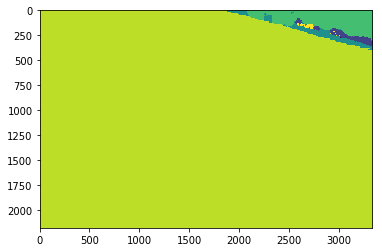

In [37]:
plt.figure()
plt.imshow(prediction_1)
plt.show()

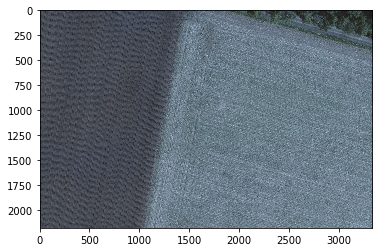

In [38]:
plt.figure()
plt.imshow(evl_image)
plt.show()

In [46]:
from scipy import misc
label = np.array(misc.imread(label_path))
print label.shape
print prediction_1.shape

(2180, 3335)
(2180, 3335)


In [47]:
from sklearn.metrics import confusion_matrix
label = label.flatten()
prediction_1 = prediction_1.flatten()
cm = confusion_matrix(y_true=label, y_pred=prediction_1, labels=range(11))

In [48]:
print cm

[[      0       0       0       0       0     229       0      21       0
     2418       0]
 [      0       0       0       0       0       0       0       0       0
        0       0]
 [      0       0       0       0       0       0       0       0       0
        0       0]
 [      0       0       0       0       0       0       0       0       0
        0       0]
 [      0       0       0       0       0       0       0       0       0
        0       0]
 [      1       4      54       0       0   42068       0    6252       0
     5345       0]
 [      0       0       0       0       0       0       0       0       0
        0       0]
 [      0       0    1194       0       0    3697       0  196546       0
      215     534]
 [      0       0       0       0       0       0       0       0       0
        0       0]
 [      0       0       0       0       0    1197       0     119       0
  6959702       0]
 [    144     446   29504       0       0   12655       0    4034     

In [49]:
tp = np.trace(cm)
tp = float(tp)
accuracy = tp / np.sum(cm)
print accuracy

0.990638213004
